In [225]:
import bisect
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PreprocessFcns import *
import scipy
from scipy.fftpack import fft
from scipy.signal import butter, filtfilt, find_peaks
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
import time
%matplotlib inline

In [226]:
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'

In [227]:
cf = RandomForestClassifier(n_estimators = 100)
le = sklearn.preprocessing.LabelEncoder()
grouper = LeaveOneGroupOut()
sns.set(font_scale = 1.5)

In [228]:
VisitNumber = {
    '2 Weeks: Time 0'   : 0,
    '2 Weeks: Time 30'  : 1,
    '2 Weeks: Time 60'  : 2,
    '2 Weeks: Time 90'  : 3,
    '2 Weeks: Time 120' : 4,
    '2 Weeks: Time 150' : 5,
    '1 Month'           : 6
}

ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [229]:
def AccFilterX(rawdata):
    '''filter raw acceleration data; filter prior to calculating magnitude; filter three axes'''

    L = len(rawdata)
    # calculate the sampling frequency of the raw data - should be about 50Hz
    Fs = L / (((pd.to_datetime(rawdata.Timestamp).values.astype(np.int64) // 10**6)[-1] - 
                               (pd.to_datetime(rawdata.Timestamp).values.astype(np.int64) // 10**6)[0]) / 1000)
    # create fifth order Butterworth bandpass filter with cutoff frequencies of 1 and 16Hz
    b, a = butter(N = 5, Wn = [1, 16], btype = 'bandpass', fs = Fs)
    # generate the filtered axes data from the butterworth fitler and reformat into dataframe to return
    filtaxes = filtfilt(b, a, rawdata[['X', 'Y', 'Z']].values, axis = 0)
    filtdata = pd.DataFrame(filtaxes, columns = ['X', 'Y', 'Z'])
    filtdata['Timestamp'] = rawdata.Timestamp.values
    filtdata = filtdata[['Timestamp', 'X', 'Y', 'Z']]
    
    return filtdata

def featureXTRACT9000(data_clip):
    '''extract features from the data clip of the relevant recording; 
    features built off of study conducted by Joen et al'''

    # filter the input raw data via the above function
    data = AccFilterX(data_clip)
    # calculate acceleration magnitude on filtered data
    data['Mag'] = np.sqrt((data[['X', 'Y', 'Z']]**2).sum(axis = 1))
    # convert Pandas timestamp values to integer epoch time
    data['ETime'] = pd.to_datetime(data.Timestamp).values.astype(np.int64) // 10**6
    # designate indices of peaks and troughs of acceleration magnitude
    peaks, _ = find_peaks(data.Mag)
    troughs, _ = find_peaks(-data.Mag)

    num_peaks = 0
    tot_amp = 0
    for peak in peaks:
        # get index of nearest trough to the right of each peak (tie peaks and troughs together)
        peak_pos = bisect.bisect(troughs, peak, lo = 0, hi = len(troughs))
        if (peak_pos == 0) or (peak_pos == len(troughs)):
            continue
        next_trough = troughs[peak_pos]
        prev_trough = troughs[peak_pos - 1]
        num_peaks += 1
        # sum height from each previous and next trough to each peak considered
        tot_amp += (data.Mag[peak] - data.Mag[prev_trough]) + (data.Mag[peak] - data.Mag[next_trough])

    # Mean Amplitude: average height from each trough (before and after) to each peak
    Mean_Amp = tot_amp / (2 * num_peaks)

    # Average Regularity: average temporal distance between peaks
    Avg_Reg = np.sum(np.diff(data.ETime[peaks])) / (len(peaks) - 1)

    # Regularity Variance: standard deviation of temporal distances between peaks
    Reg_Std = np.std(np.diff(data.ETime[peaks]))
    
    # generate FFT spectra for each axis of acceleration data
    L = len(data)
    Fs = L / (((data.ETime.values)[-1] - (data.ETime.values)[0]) / 1000)
    P1X = np.abs((fft(data.X)) / L)[:int(L / 2 + 1)]
    P1Y = np.abs((fft(data.Y)) / L)[:int(L / 2 + 1)]
    P1Z = np.abs((fft(data.Z)) / L)[:int(L / 2 + 1)]
    f = Fs * range(int(L / 2) + 1) / L
    clipFFT = pd.DataFrame()
    clipFFT['f'] = f
    clipFFT['P1X'] = P1X
    clipFFT['P1Y'] = P1Y
    clipFFT['P1Z'] = P1Z
    # include an averaged value of the FFT spectra of the three axis from which they were generated
    clipFFT['P1'] = np.mean(clipFFT[['P1X', 'P1Y', 'P1Z']], axis = 1)

    # Peak Power: maximum power in the averaged FFT spectrum
    Peak_Power = np.max(clipFFT.P1)

    # Peak Frequency: frequency corresponding to peak power of averaged FFT
    Peak_Freq = float(clipFFT.f[clipFFT.P1 == Peak_Power].values)

    # Mean Frequency: center frequency of averaged FFT based on weighted corresponding powers
    Mean_Freq = np.sum(clipFFT.f * clipFFT.P1) / np.sum(clipFFT.P1)

    # Mean Power: power corresponding to Mean Frequency of FFT
    Mean_Power = float(clipFFT.P1[clipFFT.f == min(clipFFT.f, key = lambda x: abs(x - Mean_Freq))].values)
    
    # isolate 'low freqency' FFT band with spectra values below mean frequency
    LFband = clipFFT[0:bisect.bisect(clipFFT.f, Mean_Freq, lo = 0, hi = len(clipFFT.f) - 1)]
    # 'tremor frequency' band of 6Hz worth of frequencies centered around mean freqency of spectrum
    TFband = clipFFT[bisect.bisect(clipFFT.f, (Mean_Freq - 3), lo = 0, hi = len(clipFFT.f) - 1):
                     bisect.bisect(clipFFT.f, (Mean_Freq + 3), lo = 0, hi = len(clipFFT.f) - 1)]
    # isolate 'high freqency' FFT band with spectra values above mean frequency
    HFband = clipFFT[bisect.bisect(clipFFT.f, Mean_Freq, lo = 0, hi = len(clipFFT.f) - 1):
                     bisect.bisect(clipFFT.f, 16, lo = 0, hi = len(clipFFT.f) - 1)]

    # Low Band Power: sum of the power present in the low frequency band
    L_Power = np.sum(LFband.P1)

    # Tremor Band Power: sum of the power present in the tremor frequency band
    T_Power = np.sum(TFband.P1)

    # High Band Power: sum of the power present in the high frequency band
    H_Power = np.sum(HFband.P1)

    # Total Power: sum of all power present in the averaged FFT spectrum generated
    tot_power = np.sum(clipFFT.P1)

    # Relative Low Band Power: low band power normalized by the total power
    L_Rel_Power = L_Power / tot_power

    # Relative Tremor Power: tremor power normalized by the total power
    T_Rel_Power = T_Power / tot_power

    # Relative High Power: high power normalized by the total power
    H_Rel_Power = H_Power / tot_power
    
    # calculate logs of other features to generate additional features
    # log of Mean Amplitude
    Log_MA = np.log(Mean_Amp)
    
    # log of Peak Power
    Log_PP = np.log(Peak_Power)

    # log of Mean Power
    Log_MP = np.log(Mean_Power)

    # log of Low Power
    Log_LP = np.log(L_Power)

    # log of Tremor Power
    Log_TP = np.log(T_Power)

    # log of High Power
    Log_HP = np.log(H_Power)
    
    # classify each data clip as anomaly or not based on the root mean squared error of the acceleration magnitude
    # set the threshold for which to being classifying anomalous clips
    NormRMSE = 0.004
    if (np.sqrt(np.mean((data.Mag - np.mean(data.Mag))**2))) > NormRMSE:
        anomaly = 1
    else:
        anomaly = 0
    
    # condense the features generated into an array to return
    X = np.array([Mean_Amp, Avg_Reg, Reg_Std, 
                  Peak_Power, Peak_Freq, Mean_Freq, Mean_Power, 
                  L_Power, T_Power, H_Power, 
                  L_Rel_Power, T_Rel_Power, H_Rel_Power,
                  Log_MA, Log_PP, Log_MP, Log_LP, Log_TP, Log_HP,
                  anomaly])
    
    return X

def DataAggregatorONE(file):
    '''take input recording file name, segment, and call upon previous functions to extract features and return them'''
    
    TaskFeatures = pd.DataFrame()
    
    # pull the subject, visit, and task from the input file name (i.e. 1003_1_Sitng)
    subject = file[:4]
    visit = file[5:6]
    task = file[7:]
    print(file)
    
    features_list = ['Mean_Amp', 'Avg_Reg', 'Reg_Std',
                     'Peak_Power', 'Peak_Freq', 'Mean_Freq', 'Mean_Power',
                     'L_Power', 'T_Power', 'H_Power',
                     'L_Rel_Power', 'T_Rel_Power', 'H_Rel_Power',
                     'Log_MA', 'Log_PP', 'Log_MP', 'Log_LP', 'Log_TP', 'Log_HP',
                     'Anomaly']

    # open file containing the acceleration data from the respective recording
    try:
        data = (pd.read_csv(os.path.join(path, 'TaskAcc', file + '.csv'), parse_dates = ['timestamp'])
                [['timestamp', 'x', 'y', 'z']])
        data.columns = ['Timestamp', 'X', 'Y', 'Z']
        # not all metadata information has corresponding recordings
    except(FileNotFoundError):
        print('No data found for subject %s %s visit %s' % (subject, task, visit))
        return TaskFeatures

    data = data.sort_values(by = 'Timestamp', axis = 0)
    # group data points into windows for segmenting - change modulo after tm.second to alter length (half of desired)
    data['TimeWdw'] = [(tm - datetime.timedelta(minutes = 0,
                                                    seconds = tm.second % 1.5,
                                                    microseconds = tm.microsecond)) 
                        for tm in data.Timestamp]
    # make recording index the time in epoch from the first data point of the recording
    data['TimeIdx'] = (data.Timestamp.values - data.Timestamp.values[0]).astype('timedelta64[ms]').astype(int)
    data = data.set_index('TimeIdx')

    F = []
    for t in data.TimeWdw.unique():
        # segment data recording into clips according to time window groups that overlap by 50%
        # change timedelta value with the modulo above to alter window size (half of desired to get overlap)
        clip = data.loc[(data.TimeWdw == t) | (data.TimeWdw == (t + np.timedelta64(1500, 'ms')))]
        # eliminate empty clips of clips that do not contain near desired length of data (~50 len per sec of clip)
        if (clip.empty or (len(clip.TimeWdw) < 100)):
            continue
        # extract features from the data clip of the recording using the functions above
        F.append(featureXTRACT9000(clip[['Timestamp', 'X', 'Y', 'Z']]))

    # put the features generated from all of the clips from the given recording into a dataframe to return
    TaskFeatures = pd.DataFrame(data = F, columns = features_list, dtype = 'float32')    
    
    return TaskFeatures

# initialize timer
s_time = time.time()

# open metadata frile from which to aggregate data and extract features
clinicData = pd.read_csv(os.path.join(path, 'Metadata Tables', 'Table4.csv'))
# only consider sitting and standing data for the anomaly analysis as it is currently constructed
clinicData = clinicData[(clinicData.TaskAbb == 'Sitng') | (clinicData.TaskAbb == 'Stndg')]

DataFeatures = pd.DataFrame()
for task in clinicData.iterrows():
    # build recording file name from the information in one row of the metadata table 
    file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
    # acquire the features of the recording relating to the row of the metadata table
    TaskFeatures = DataAggregatorONE(file)
    if TaskFeatures.empty:
        continue
    featcols = list(TaskFeatures.columns)
    
    # append relevant metadata information to the dataframe of extracted features
    TaskFeatures['SubjID'] = int(task[1]['SubjID'])
    # utilize the visitnumber dictionary to turn descriptive visit to integer
    TaskFeatures['Visit'] = VisitNumber[task[1]['Visit']]
    TaskFeatures['TaskAbb'] = task[1]['TaskAbb']
    TaskFeatures['Clip'] = range(len(TaskFeatures))
    # only concerned with the tremor score of the hand on which the apple watch is worn
    TaskFeatures['Tremor'] = task[1]['Tremor - ' + task[1]['Side']]
    
    # realign columns of dataframe
    cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor'] + featcols
    TaskFeatures = TaskFeatures[cols]
    
    # initialize or append to continuous dataframe for each recording in metadata
    if DataFeatures.empty:
        DataFeatures = TaskFeatures
        continue
    DataFeatures = pd.concat([DataFeatures, TaskFeatures], ignore_index = True)

# save the datafeatures file to the destintion specified in early cell of script
DataFeatures.to_csv(os.path.join(dest, 'Clinic Data', 'DataFeaturesSEOUL.csv'), index = False)

# communicate time to generate file of feature extraction
print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')

1003_0_Sitng
1003_0_Stndg
1003_1_Sitng
1003_1_Stndg
1003_2_Sitng
1003_2_Stndg
1003_3_Sitng
1003_3_Stndg
1003_4_Sitng
1003_4_Stndg
1003_5_Sitng
1003_5_Stndg
1003_6_Sitng
No data found for subject 1003 Sitng visit 6
1003_6_Stndg
No data found for subject 1003 Stndg visit 6
1004_0_Sitng
1004_0_Stndg
1004_1_Sitng
1004_1_Stndg
1004_2_Sitng
1004_2_Stndg
1004_3_Sitng
1004_3_Stndg
1004_4_Sitng
1004_4_Stndg
1004_5_Sitng
No data found for subject 1004 Sitng visit 5
1004_5_Stndg
No data found for subject 1004 Stndg visit 5
1004_6_Sitng
1004_6_Stndg
1005_0_Sitng
1005_0_Stndg
No data found for subject 1005 Stndg visit 0
1005_1_Sitng
1005_1_Stndg
1005_2_Sitng
1005_2_Stndg
1005_3_Sitng
1005_3_Stndg
1005_4_Sitng
No data found for subject 1005 Sitng visit 4
1005_4_Stndg
No data found for subject 1005 Stndg visit 4
1005_5_Sitng
No data found for subject 1005 Sitng visit 5
1005_5_Stndg
No data found for subject 1005 Stndg visit 5
1005_6_Sitng
No data found for subject 1005 Sitng visit 6
1005_6_Stndg
No d

0 hours 4 minutes 24 seconds


In [230]:
# get recordings scored for tremor that do not contain any anomalous clips
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'DataFeaturesSEOUL.csv'))
print('Tremor Recordings without Anomaly:')
n = 0
i = 0
for task in DataFeatures.TaskAbb.unique():
    TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
    for subj in TDataFeatures.SubjID.unique():
        TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == subj]
        for visit in TSDataFeatures.Visit.unique():
            TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
            if all(TSVDataFeatures.Tremor > 0):
                n += 1
            if all(TSVDataFeatures.Tremor > 0) and all(TSVDataFeatures.Anomaly == 0):
                i += 1
                print(str(int(TSVDataFeatures.SubjID.iloc[-1])) + '_' + 
                      str(TSVDataFeatures.Visit.iloc[-1]) + '_' + TSVDataFeatures.TaskAbb.iloc[-1])
# i = number of recordings scored for tremor that do not contain any anomalous clips
print(i)
print('Tremor Recordings:')
# n = total number of recordings for provided tasks (sitting and standing according to metadata filtering)
print(n)
print('--------------------------------------------------------------------------------------')
# get recordings scored as normal that contain all anomalous clips (consider above group more heavily)
print('Normal Recordings entirely Anomaly:')
i = 0
n = 0
for task in DataFeatures.TaskAbb.unique():
    TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
    for subj in TDataFeatures.SubjID.unique():
        TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == subj]
        for visit in TSDataFeatures.Visit.unique():
            TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
            if all(TSVDataFeatures.Tremor == 0):    
                n += 1
            if all(TSVDataFeatures.Tremor == 0) and all(TSVDataFeatures.Anomaly == 1):
                i += 1
                print(str(int(TSVDataFeatures.SubjID.iloc[-1])) + '_' + 
                      str(TSVDataFeatures.Visit.iloc[-1]) + '_' + TSVDataFeatures.TaskAbb.iloc[-1])
# i = number of recordings scored for tremor that do not contain any anomalous clips
print(i)
print('Normal Recordings:')
# n = total number of recordings for provided tasks (sitting and standing)
print(n)

Tremor Recordings without Anomaly:
1050_1_Sitng
1
Tremor Recordings:
58
--------------------------------------------------------------------------------------
Normal Recordings entirely Anomaly:
1003_1_Sitng
1003_2_Sitng
1003_3_Sitng
1024_2_Sitng
1024_6_Sitng
1029_5_Sitng
1038_3_Sitng
1003_1_Stndg
1003_2_Stndg
1003_5_Stndg
1016_2_Stndg
1016_3_Stndg
1023_1_Stndg
1024_3_Stndg
1024_4_Stndg
1024_5_Stndg
1029_6_Stndg
1038_0_Stndg
1043_3_Stndg
1043_4_Stndg
1043_5_Stndg
1048_1_Stndg
1049_1_Stndg
1049_2_Stndg
1051_1_Stndg
25
Normal Recordings:
213


In [241]:
def DetectDiscernAnomalyModel(tasks, binary, anomaly, featuresfile):
    '''two-step model:
    first predicts whether a clip has an anomaly
    then predicts whether anomalous clips are characteristic of tremor or normal
    scores attributed on the scale of the full recording:
    recordings without anomalies are deemed normal
    predictions on anomaly clips inform the predicted score of the overall recording
    
    tasks: list of the abbreviated tasks to be considered (built for sitting and standing)
    binary: True or False - whether or not all scores or symptomatic/normal should be labels
    anomaly: True or False - whether or not clips should be predicted, scored, and filterd by anomaly
    featuresfile: name of features file (with .csv) to use for training and testing model'''
    
    # create dictionary to convert from scores to binary classification
    groupDict = {0: 'Normal', 1: 'Symptomatic', 2: 'Symptomatic', 3: 'Symptomatic', 4: 'Symptomatic'}
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', featuresfile))
    # isolate datafeatures corresponding to tasks of interest
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    # some datafeatures contain 'nan' values and must be removed
    DataFeatures = DataFeatures[~np.isnan(DataFeatures['Tremor'].values)]
    
    features_list = list(DataFeatures.columns[5:53])
    
    # train model to predict whether clips should be scored as anomalous first
    if anomaly:
    
        # consolidate features from datafeatures file for training
        X = DataFeatures[features_list].values
        # train to predict whether the clip is an anomaly (1) or not (0)
        Y = DataFeatures['Anomaly'].values
        # encode the anomaly labels
        le.fit(Y)
        Y = le.transform(Y)

        TestLabs = []
        PredLabs = []
        testInds = []
        # split training and testing sets by subject, with each testing set being a subject left out
        for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):

            TrainFeat = X[trainInd]
            TrainLab = Y[trainInd]
            TestFeat = X[testInd]
            TestLab = Y[testInd]

            # fit random forest model using the training dataset
            cf.fit(TrainFeat, TrainLab)
            # use the fit model to predict whether the clips of the test features are anomalous
            PredLab = cf.predict(TestFeat)
            # return the labels to their original state (remove the encoding)
            TestLab = le.inverse_transform(TestLab)
            PredLab = le.inverse_transform(PredLab)

            # add the test labels and predicted labels to a dataframe, organized by the indices spawning from datafeatures
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        AnomPred = pd.DataFrame(index = testInds)
        AnomPred['TestLabs'] = TestLabs
        AnomPred['PredLabs'] = PredLabs

        Recordings = []
        Subjects = []
        Scores = []
        Predictions = []
        Densities = []
        for task in DataFeatures.TaskAbb.unique():
            TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
            for sub in TDataFeatures.SubjID.unique():
                TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == sub]
                for visit in TSDataFeatures.Visit.unique():
                    TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
                    TSVAnomPred = AnomPred.iloc[TSVDataFeatures.index]

                    if binary:
                        # rate recordings containing clips all predicted to not be anomalous as normal
                        if all(TSVAnomPred.PredLabs == 0):
                            # relevant task recording
                            Recordings = Recordings + [str(sub) + '_' + str(visit) + '_' + task]
                            # corresponding subject
                            Subjects = Subjects + [str(sub)]
                            # original clinician score
                            Scores = Scores + [groupDict[TSVDataFeatures.Tremor.unique()[0]]]
                            # predicted designation based on absence of anomalies
                            Predictions = Predictions + ['Normal']
                            # relative presence of symptomatic clips in recordings (0 in this case)
                            Densities = Densities + [float(0)]
                    else:
                        # give recordings containing clips all predicted to not be anomalous a score of 0
                        if all(TSVAnomPred.PredLabs == 0):
                            # relevant task recording
                            Recordings = Recordings + [str(sub) + '_' + str(visit) + '_' + task]
                            # corresponding subject
                            Subjects = Subjects + [str(sub)]
                            # original clinician score
                            Scores = Scores + [TSVDataFeatures.Tremor.unique()[0]]
                            # predicted designation based on absence of anomalies
                            Predictions = Predictions + [float(0)]
                            # relative presence of symptomatic clips in recordings (0 in this case)
                            Densities = Densities + [float(0)]

        # limit datafeatures file to only clips predicted to be anomalous
        AnomFeatures = DataFeatures[AnomPred.PredLabs == 1].reset_index(drop = True)
        features_list = list(AnomFeatures.columns[5:53])
        
    else:
        Recordings = []
        Subjects = []
        Scores = []
        Predictions = []
        Densities = []
        AnomFeatures = DataFeatures
    
    X = AnomFeatures[features_list].values
    # labels now the score provided by clinician
    if binary:
        # consider only whether or not a recording contains a symptom
        Y = AnomFeatures['Tremor'].apply(lambda x: groupDict[x]).values
    else:
        # consider each possible score individually (varrying tremor severity)
        Y = AnomFeatures['Tremor'].values
    # encode the labels - for training and testing the model (especially necessay for using string designations)
    le.fit(Y)
    Y = le.transform(Y)
    
    FeatImp = np.zeros(shape = (1, 1))
    TestLabs = []
    PredLabs = []
    testInds = []
    ProbLabCV = []
    TestLabCV = []
    plt.figure(figsize = (12, 10))
    # split training and testing sets by subject, with each testing set being a subject left out
    for trainInd, testInd in grouper.split(X, Y, groups = AnomFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        
        # fit the model on the trianing set of features and clinician labels that correspond
        cf.fit(TrainFeat, TrainLab)
        
        # acquire feature imporatances of features training the model
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_

        # use the fit model to predict the score (binary or not) of each clip in testing set
        PredLab = cf.predict(TestFeat)
        # reverse the label encoding to return original classes
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        
        # add the test labels and predicted labels to a dataframe, organized by the indices spawning from datafeatures
        TestLabs = TestLabs + list(TestLab)
        PredLabs = PredLabs + list(PredLab)
        testInds = testInds + list(testInd)
    
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    
    for task in AnomFeatures.TaskAbb.unique():
        TAnomFeatures = AnomFeatures[AnomFeatures.TaskAbb == task]
        for sub in TAnomFeatures.SubjID.unique():
            TSAnomFeatures = TAnomFeatures[TAnomFeatures.SubjID == sub]
            for visit in TSAnomFeatures.Visit.unique():
                TSVAnomFeatures = TSAnomFeatures[TSAnomFeatures.Visit == visit]
                TSVTestPred = TestPred.iloc[TSVAnomFeatures.index]
                
                if binary:
                    if any(TSVTestPred.PredLabs == 'Symptomatic'):
                        
                        # set threshold for number of symptomatic clips necessary for recording to be scored
                        if TSVTestPred.PredLabs.value_counts()['Symptomatic'] > 1:
                            
                            Recordings = Recordings + [str(sub) + '_' + str(visit) + '_' + task]
                            Subjects = Subjects + [str(sub)]
                            Scores = Scores + [TSVTestPred.TestLabs.unique()[0]]
                            Predictions = Predictions + ['Symptomatic']
                            Densities = Densities + [TSVTestPred.PredLabs.value_counts()['Symptomatic'] / 
                                                 len(TSVTestPred.PredLabs)]
                        # not enough clips present in recording to be considered symptomatic
                        else:
                            Recordings = Recordings + [str(sub) + '_' + str(visit) + '_' + task]
                            Subjects = Subjects + [str(sub)]
                            Scores = Scores + [TSVTestPred.TestLabs.unique()[0]]
                            Predictions = Predictions + ['Normal']
                            Densities = Densities + [float(0)]
                    
                    # no clips in the recording predicted to be symptomatic
                    else:
                        Recordings = Recordings + [str(sub) + '_' + str(visit) + '_' + task]
                        Subjects = Subjects + [str(sub)]
                        Scores = Scores + [TSVTestPred.TestLabs.unique()[0]]
                        Predictions = Predictions + ['Normal']
                        Densities = Densities + [float(0)]
                
                # all scores considered (not just binary)
                else:
                    Recordings = Recordings + [str(sub) + '_' + str(visit) + '_' + task]
                    Subjects = Subjects + [str(sub)]
                    Scores = Scores + [TSVTestPred.TestLabs.unique()[0]]
                    # prediction considered the maximum score predicted for a clip within the recording
                    Predictions = Predictions + [np.max(TSVTestPred.PredLabs)]
                    if any(TSVTestPred.PredLabs == 0):
                        Densities = Densities + [1 - (TSVTestPred.PredLabs.value_counts()[0] / len(TSVTestPred.PredLabs))]
                    else:
                        Densities = Densities + [float(1)]
                        
    # add corresponding subject, score, prediction, and density organized by recording to dataframe to return
    RecordingAnalysis = pd.DataFrame({'Subject': Subjects, 
                                      'Score': Scores, 'Prediction': Predictions, 'Density': Densities}, 
                                     index = Recordings)
    # output the overall accuracy of the model in classifying the recordings
    print('Model Accuracy = ' + str((len(RecordingAnalysis[RecordingAnalysis.Score == RecordingAnalysis.Prediction])
                                     / len(RecordingAnalysis)) * 100))
    # format the scores and predictions for display in a confusion matrix
    CM = sklearn.metrics.confusion_matrix(RecordingAnalysis.Score.values, RecordingAnalysis.Prediction.values, 
                                          labels = le.classes_)
                    
    for i in range(len(CM)):
        # normalize the values of the confusion matrix so each row contains percents
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100
        
    if binary:

# -------------------------------------------------------------------------------------------------------------------------
        # plot ROC curves for each subject validation iteration
        plt.figure(figsize = (12, 10))
        for subject in RecordingAnalysis.Subject.unique():
            SRecordingAnalysis = RecordingAnalysis[RecordingAnalysis.Subject == subject]
            if (len(SRecordingAnalysis) == 1):
                continue
            # true labels: scores of the recording analysis dataframe (clincian scores)
            TL = SRecordingAnalysis.Score.apply(lambda x: 1 if x == 'Symptomatic' else 0).values
            if all(TL == 0):
                continue
            # predicted labels: density values - relative number of symptomatic clips in the recording
            PL = SRecordingAnalysis.Density.values
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 20)
            plt.ylabel('True Positive Rate', fontsize = 20)
        plt.legend(RecordingAnalysis.Subject.unique())
        plt.show()
            
# -------------------------------------------------------------------------------------------------------------------------

        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    # plot the confusion matrix of the validation results for scoring overall recordings
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_, vmin = 0, vmax = 100, annot = True)
    plt.xticks(fontsize = 14)
    if binary:
        plt.yticks(fontsize = 14)
    else:
        plt.yticks(fontsize = 14, rotation = 0)
    plt.xlabel('Predicted', fontsize = 16)
    plt.ylabel('Test', fontsize = 16)
    
    # generate barplot of feature importance values
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return RecordingAnalysis

Model Accuracy = 89.66789667896678


<Figure size 864x720 with 0 Axes>

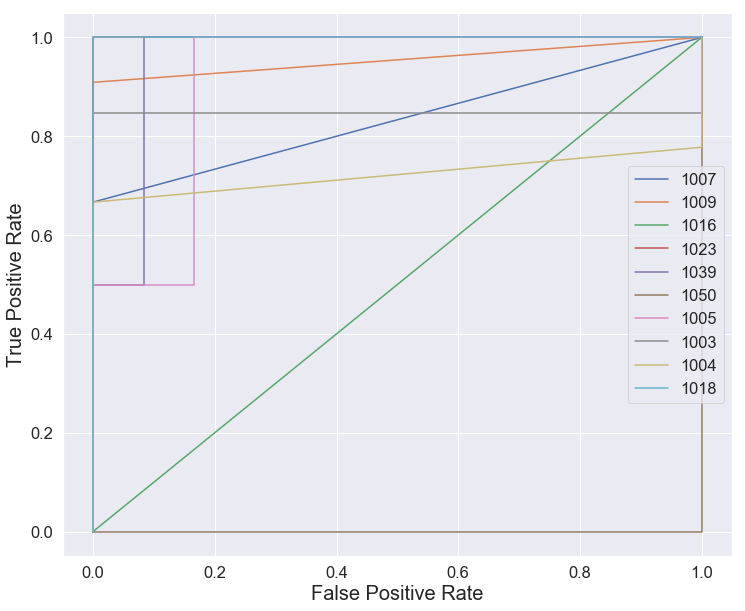

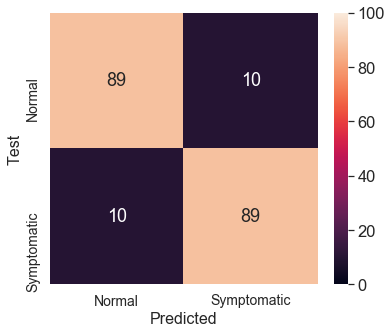

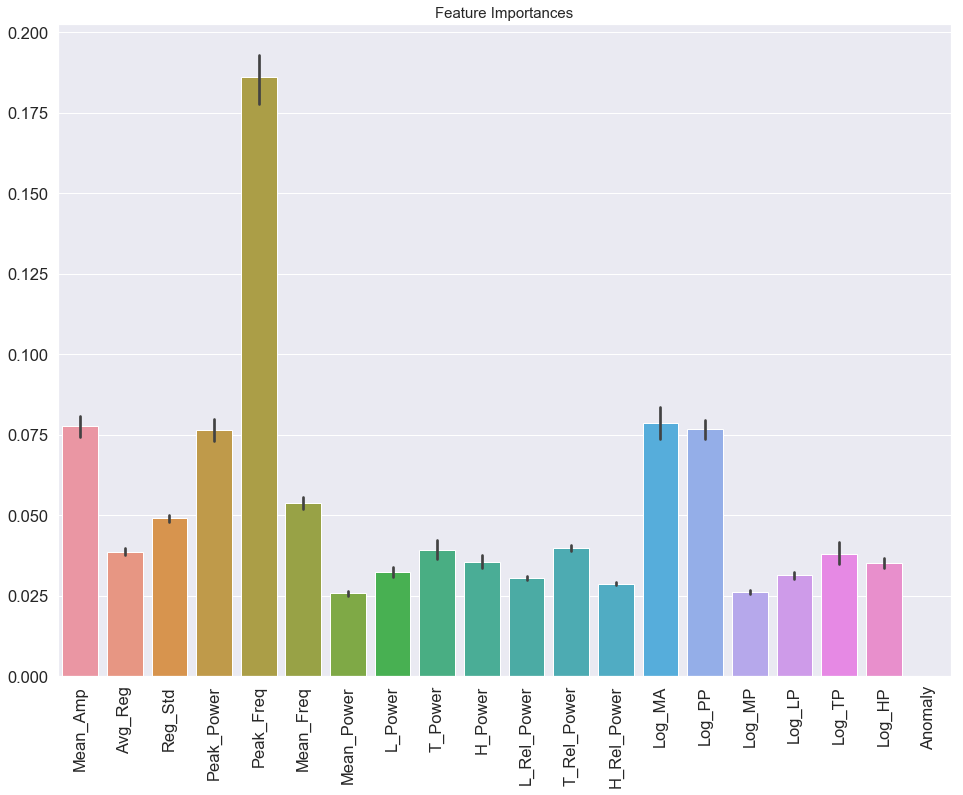

In [242]:
RecordingAnalysis = DetectDiscernAnomalyModel(['Stndg', 'Sitng'], True, True, 'DataFeaturesSEOUL.csv')

In [243]:
RecordingAnalysis

,Subject,Score,Prediction,Density
1007_1_Sitng,1007,Normal,Normal,0.000000
1009_1_Sitng,1009,Normal,Normal,0.000000
1009_2_Sitng,1009,Normal,Normal,0.000000
1009_5_Sitng,1009,Normal,Normal,0.000000
1016_0_Sitng,1016,Normal,Normal,0.000000
1016_6_Sitng,1016,Normal,Normal,0.000000
1023_0_Sitng,1023,Normal,Normal,0.000000
1023_6_Sitng,1023,Normal,Normal,0.000000
1039_0_Sitng,1039,Normal,Normal,0.000000
1039_3_Sitng,1039,Normal,Normal,0.000000
